In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from lecilab_behavior_analysis.utils import load_example_data
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
mouse = "mouse1"
df = load_example_data(mouse)

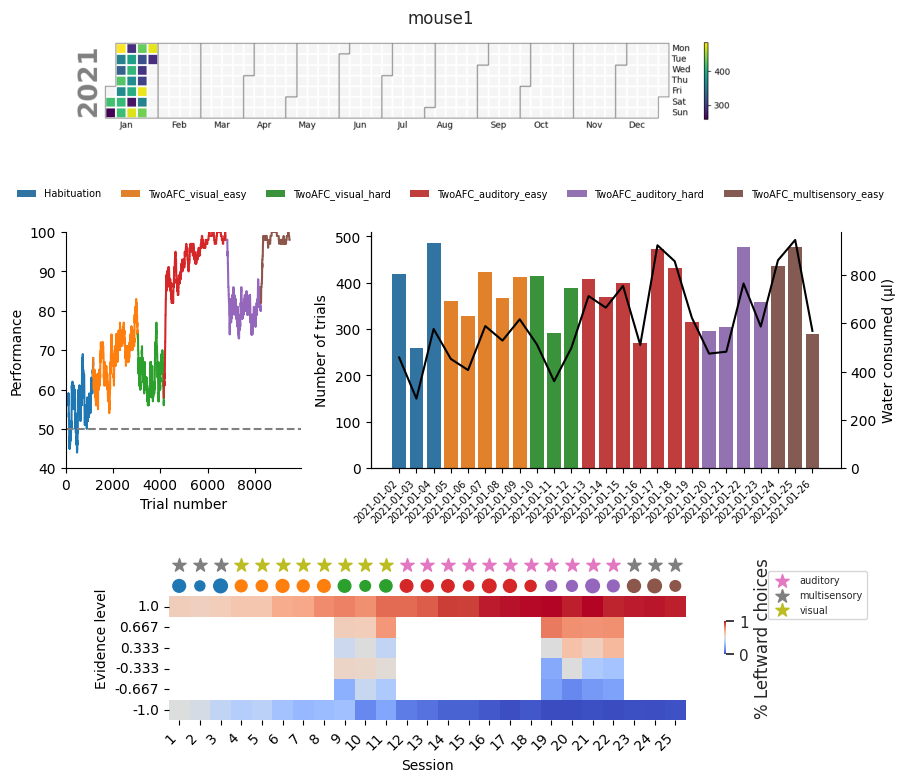

In [4]:
from lecilab_behavior_analysis.figure_maker import subject_progress_figure
fig = subject_progress_figure(df, mouse, perf_window=100)


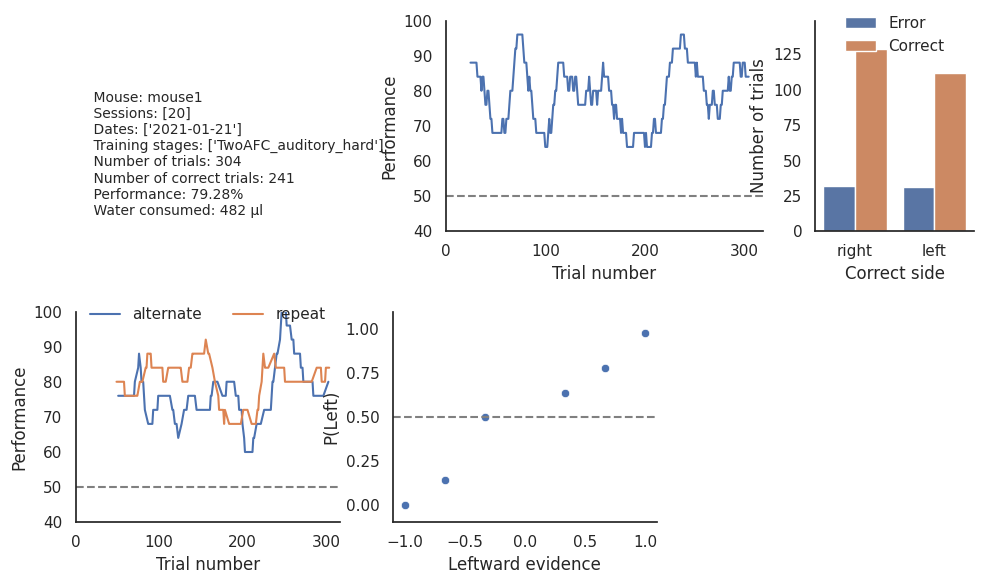

In [5]:
from lecilab_behavior_analysis.figure_maker import session_summary_figure
# select the session you want to plot
session = 20
sdf = df[df["session"] == session]
fig = session_summary_figure(sdf, mouse, perf_window=25)

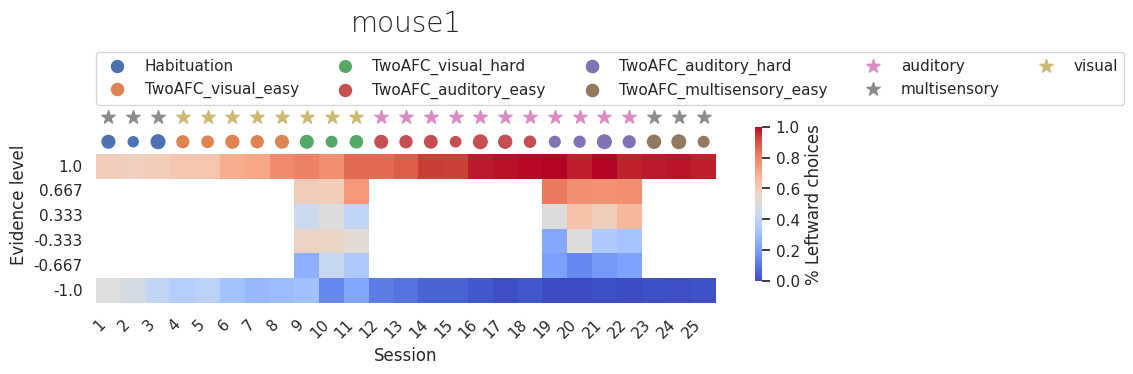

In [6]:
from lecilab_behavior_analysis.df_transforms import summary_matrix
from lecilab_behavior_analysis.plots import summary_matrix_plot

sm, dict = summary_matrix(df)
fig = plt.subplots(figsize=(10, 10))
summary_matrix_plot(sm, dict, "mouse1")
plt.show()

/home/emma/Desktop/EloiJacomet/Github/lecilab-behavior-analysis/lecilab_behavior_analysis/plots.py:339: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time_Between_Trials'] = df['Port2_OUT'].diff()
/home/emma/Desktop/EloiJacomet/Github/lecilab-behavior-analysis/lecilab_behavior_analysis/plots.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Reaction_Time'] = np.where(df['Port1_IN'].notna(), df['Port1_IN'] - df['Port2_OUT'], df['Port3_IN'] - df['Port2_OUT'])


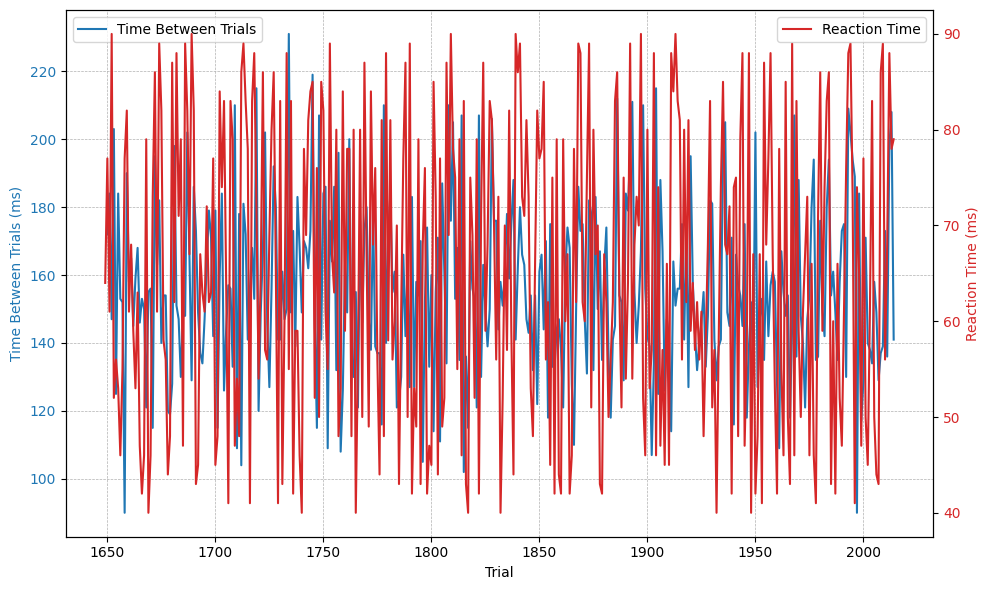

In [20]:
from lecilab_behavior_analysis.plots import plot_time_between_trials_and_reaction_time
session = 5
sdf = df[df["session"] == session]
fig = plot_time_between_trials_and_reaction_time(sdf)
